# Deep Kalman Filter Experiments

In [1]:
# Experiment with barcrawl data
import numpy as np
from hmmlearn import hmm
from hmmlearn import vhmm
from data_combined_reader import load_combined_data
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from scipy.special import softmax
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import KFold  # Cross-validation tools
import sklearn_crfsuite
from imblearn.over_sampling import SMOTE
from copy import deepcopy

# Data windowing settings (this is actually read from PKL data files,
# but we provide a default here)
DEFAULT_WINDOW = 400  # 10 second window: 10 seconds * 40Hz = 400 samples per window

window = DEFAULT_WINDOW

TEST_RATIO = 0.30

PIDS = [
    "BK7610",
    "BU4707",
    "CC6740",
    "DC6359",
    "DK3500",
    "HV0618",
    "JB3156",
    "JR8022",
    "MC7070",
    "MJ8002",
    "PC6771",
    "SA0297",
    "SF3079",
]

from scipy.signal import butter, filtfilt

# Apply butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    y = filtfilt(b, a, data, padlen=len(data) - 1)
    return y

window, train_data_set, test_data_set = load_combined_data(PIDS, TEST_RATIO, True)
Xtr, _, Ytr = zip(*train_data_set)
Xva, _, Yva = zip(*test_data_set)
sequence_length = Xtr[0].shape[0]

#Strip timestamps
Xtr = np.array([x[:, 1:] for x in Xtr])
Xva = np.array([x[:, 1:] for x in Xva])

# #Low pass filter
# SAMPLE_RATE = 40  # Hz
# FREQ_CUTOFF = 1  # Hz
# print("Apply Lowpass filter")
# Xtr[:, :, 0] = np.array([butter_lowpass_filter(x[:, 0], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xtr])
# Xtr[:, :, 1] = np.array([butter_lowpass_filter(x[:, 1], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xtr])
# Xtr[:, :, 2] = np.array([butter_lowpass_filter(x[:, 2], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xtr])
# Xva[:, :, 0] = np.array([butter_lowpass_filter(x[:, 0], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xva])
# Xva[:, :, 1] = np.array([butter_lowpass_filter(x[:, 1], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xva])
# Xva[:, :, 2] = np.array([butter_lowpass_filter(x[:, 2], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xva])


def print_metrics(y_true, y_preds):
    c_matrix = confusion_matrix(y_true, y_preds)
    t_pos = c_matrix[1][1]
    t_neg = c_matrix[0][0]
    f_pos = c_matrix[0][1]
    f_neg = c_matrix[1][0]

    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    acc = accuracy_score(y_true, y_preds)
    b_acc = balanced_accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    sober_data = [d for d in list(zip(y_true, y_preds)) if d[0] == 0]
    sober_true = np.array([d[0] for d in sober_data])
    sober_pred = np.array([d[1] for d in sober_data])
    sober_acc = accuracy_score(sober_true, sober_pred)

    drunk_data = [d for d in list(zip(y_true, y_preds)) if d[0] == 1]
    drunk_true = np.array([d[0] for d in drunk_data])
    drunk_pred = np.array([d[1] for d in drunk_data])
    drunk_acc = accuracy_score(drunk_true, drunk_pred)

    print("Accuracy = %f" % acc)
    print("Precision = %f" % precision)
    print("Recall = %f" % recall)
    print("F1-score = %f" % f1)
    print("Balanced Accuracy = %f" % b_acc)
    print("Sober Accuracy = %f" % sober_acc)
    print("Drunk Accuracy = %f" % drunk_acc)
    print("False negatives = %d" % f_neg)
    print("False postives = %d" % f_pos)
    print("True negatives = %d" % t_neg)
    print("True positives = %d" % t_pos)

    fig, ax = plt.subplots(figsize=(5, 5))
    metrics.RocCurveDisplay.from_predictions(
        y_true,
        y_preds,
        name=f"ROC curve",
        ax=ax,
    )

    plt.axis("square")
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    # plt.title("ROC Curves for Shuffled Data")
    plt.legend()


Reading in all data
Shuffle window data?: True
Shuffling windows randomly
Number of Windows for Training: 92689
Number of Windows for Testing: 39736


## Check CUDA Device

In [2]:
import torch

# Check if CUDA is available
for i in range(torch.cuda.device_count()):
   print("cuda:%d=%s" % (i, torch.cuda.get_device_properties(i).name))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Pytorch device: ", device)

cuda:0=NVIDIA GeForce RTX 3090
cuda:1=NVIDIA GeForce GTX 1050 Ti with Max-Q Design
Pytorch device:  cuda:0


## Deep Kalman Filter

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import graphviz
from torchview import draw_graph

dropout = 0.1
log_var_clamp = 50

# DKF Models
class InferenceModel(nn.Module):
    """
    Inference Model:
    Represents q(z_t | x_{1:t}), the approximate posterior distribution
    of the latent state given the observed data.
    """
    def __init__(self, input_dim, hidden_dim, state_dim):
        super(InferenceModel, self).__init__()
        # GRU for inference: q(z_t | x_{1:t})
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        # Mean and log variance for the latent state
        self.fc_mean = nn.Linear(hidden_dim, state_dim)
        self.fc_logvar = nn.Linear(hidden_dim, state_dim)
    
    def forward(self, x):
        h, _ = self.rnn(x) 
        h = self.dropout(h)
        mean = self.fc_mean(h) 
        logvar = self.fc_logvar(h)
        return mean, logvar

class StateTransitionModel(nn.Module):
    """
    State Transition Model:
    Represents p(z_t | z_{t-1}), the probability of the current state
    given the previous state.
    """
    def __init__(self, state_dim, hidden_dim):
        super(StateTransitionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        # Mean and log variance for the prior state
        self.fc_mean = nn.Linear(hidden_dim, state_dim)
        self.fc_logvar = nn.Linear(hidden_dim, state_dim)
    
    def forward(self, z_prev):
        #h, _ = self.rnn(z_prev) 
        h = torch.relu(self.fc1(z_prev))
        h = self.dropout(h)
        mean = self.fc_mean(h)  
        logvar = self.fc_logvar(h)
        return mean, logvar

    
# Define the neural network for the observation model
class EmissionModel(nn.Module):
    """
    Emission Model:
    Represents p(x_t | z_t), the probability of the observed data
    given the current state.
    """
    def __init__(self, state_dim, hidden_dim, output_dim):
        super(EmissionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_logvar = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, state):
        h = torch.relu(self.fc1(state))
        h = self.dropout(h)
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

class DeepKalmanFilter(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, lr, device):
        super(DeepKalmanFilter, self).__init__()
        self.device = device
        self.state_dim = state_dim

        # Initialize the models
        self.inference_model = InferenceModel(input_dim, hidden_dim, state_dim).to(device)
        self.state_transition_model = StateTransitionModel(state_dim, hidden_dim).to(device)
        self.emission_model = EmissionModel(state_dim, hidden_dim, input_dim).to(device)
        
        # Loss function and optimizer
        self.criterion = nn.GaussianNLLLoss()
        self.optimizer = optim.Adam(
            list(self.inference_model.parameters()) +
            list(self.state_transition_model.parameters()) +
            list(self.emission_model.parameters()), lr=lr)
        
    def train(self, dataloader, num_epochs : int = 10, calc_log_likelihoods : bool = False):
        """
        Train DKF on a dataset for given number of epochs
        Can optionally calculate average log likelihoods per epoch
        """
        self.inference_model.train()
        self.state_transition_model.train()
        self.emission_model.train()

        training_log_likelihoods = []
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            epoch_loss = 0
            for input_data in dataloader:
                input_data = input_data.to(self.device)
                
                self.optimizer.zero_grad()
                
                # Forward pass through inference model to get inferred states
                mean, logvar = self.inference_model(input_data)
                logvar = torch.clamp(logvar, min=-log_var_clamp, max=log_var_clamp)  # Clamping logvar to avoid extreme values
                std = torch.exp(0.5 * logvar)
                
                # Using rsample for reparameterization
                qz = torch.distributions.Normal(mean, std)
                z = qz.rsample()  # Reparameterization trick
                
                # Forward pass through state transition model to predict next states
                prior_mean, prior_logvar = self.state_transition_model(z)
                prior_logvar = torch.clamp(prior_logvar, min=-log_var_clamp, max=log_var_clamp)
                prior_std = torch.exp(0.5 * prior_logvar)
                
                # Create the prior distribution
                pz = torch.distributions.Normal(prior_mean, prior_std)
                
                # Compute KL divergence loss using built-in PyTorch function
                kld_loss = torch.distributions.kl_divergence(qz, pz).sum(dim=-1).mean()
                
                # Decode the latent states
                decoded_mean, decoded_logvar = self.emission_model(z)
                decoded_logvar = torch.clamp(decoded_logvar, min=-log_var_clamp, max=log_var_clamp)
                
                # Create a variance tensor from log variance
                decoded_var = torch.exp(decoded_logvar)
                
                # Compute reconstruction loss (NLL)
                nll_loss = self.criterion(decoded_mean, input_data, decoded_var)
                
                # Total loss
                loss = (nll_loss + kld_loss) / input_data.size(0)  # Normalize by batch size
                
                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item()
            
            if calc_log_likelihoods:
                #Feed forward to measure log likelihood
                avg_log_likelihood = np.array(self.score(dataloader, False)).mean()
                training_log_likelihoods.append(avg_log_likelihood)

            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}, Duration: {epoch_duration:.2f} seconds')

        return training_log_likelihoods

    def generate(self, seq_length : int, num_sequences : int = 1):
        """
        Generate sequences of given length
        """
        self.inference_model.eval()
        self.state_transition_model.eval()
        self.emission_model.eval()
        
        samples = []
        with torch.no_grad():
            for _ in range(num_sequences):
                # Sample initial latent state
                z = torch.randn(1, seq_length, self.state_dim).to(self.device)
                
                # Use the prior distribution to sample latent states
                prior_mean, prior_logvar = self.state_transition_model(z)
                prior_logvar = torch.clamp(prior_logvar, min=-log_var_clamp, max=log_var_clamp)
                prior_std = torch.exp(0.5 * prior_logvar)
                pz = torch.distributions.Normal(prior_mean, prior_std)
                z = pz.rsample()

                # Decode the latent states
                decoded_mean, _ = self.emission_model(z)
                samples.append(decoded_mean.cpu().squeeze(0).numpy())

        return samples

    def score(self, dataloader, eval : bool = True):
        """
        Outputs log-likelihood of data
        """
        if eval:
            self.inference_model.eval()
            self.state_transition_model.eval()
            self.emission_model.eval()
        
        log_probs = []
        with torch.no_grad():
            for input_data in dataloader:
                input_data = input_data.to(self.device)

                # Forward pass through inference model to get inferred states
                mean, logvar = self.inference_model(input_data)
                logvar = torch.clamp(logvar, min=-log_var_clamp, max=log_var_clamp)
                std = torch.exp(0.5 * logvar)
                qz = torch.distributions.Normal(mean, std)  # Approximate posterior

                # Forward pass through state transition model to predict next states
                prior_mean, prior_logvar = self.state_transition_model(mean)
                prior_logvar = torch.clamp(prior_logvar, min=-log_var_clamp, max=log_var_clamp)
                prior_std = torch.exp(0.5 * prior_logvar)
                pz = torch.distributions.Normal(prior_mean, prior_std)  # Prior
                
                # Compute KL divergence using torch.distributions.kl_divergence
                kld_loss = torch.distributions.kl_divergence(qz, pz).sum(dim=(-1, -2))
                
                # Decode the latent states
                decoded_mean, decoded_logvar = self.emission_model(mean)
                decoded_logvar = torch.clamp(decoded_logvar, min=-20, max=20)
                decoded_std = torch.exp(0.5 * decoded_logvar)
                px = torch.distributions.Normal(decoded_mean, decoded_std)
                
                # Compute log likelihood under the observation model
                log_likelihood = px.log_prob(input_data).sum(dim=(-1, -2))
                
                # Combine log likelihood and KL divergence
                elbo = log_likelihood - kld_loss              

                # Append ELBO for each sequence
                log_probs.extend(elbo.cpu().tolist())

        return log_probs

    def extract_latent_features(self, dataloader):
        """
        Extract features from latent states for classification
        """
        self.inference_model.eval()
        self.state_transition_model.eval()
        self.emission_model.eval()

        all_features = []
        with torch.no_grad():
            for input_data in dataloader:
                input_data = input_data.to(self.device)

                # Inference model to get inferred states
                mean, logvar = self.inference_model(input_data)
                logvar = torch.clamp(logvar, min=-log_var_clamp, max=log_var_clamp)
                std = torch.exp(0.5 * logvar)
                z = mean  # You can also use z = mean + std * torch.randn_like(std) for sampling

                # Calculate additional statistics on the latent states
                mean_mean = mean.mean(dim=1)
                mean_std = mean.std(dim=1)
                mean_max = mean.max(dim=1).values
                mean_min = mean.min(dim=1).values

                # Calculate the ELBO score (already in your score method)
                prior_mean, prior_logvar = self.state_transition_model(mean)
                prior_logvar = torch.clamp(prior_logvar, min=-log_var_clamp, max=log_var_clamp)
                prior_std = torch.exp(0.5 * prior_logvar)
                pz = torch.distributions.Normal(prior_mean, prior_std)
                qz = torch.distributions.Normal(mean, std)
                kld_loss = torch.distributions.kl_divergence(qz, pz).sum(dim=(-1, -2))
                decoded_mean, decoded_logvar = self.emission_model(mean)
                decoded_logvar = torch.clamp(decoded_logvar, min=-20, max=20)
                decoded_std = torch.exp(0.5 * decoded_logvar)
                px = torch.distributions.Normal(decoded_mean, decoded_std)
                log_likelihood = px.log_prob(input_data).sum(dim=(-1, -2))
                elbo = log_likelihood - kld_loss

                # Concatenate all features along the second axis
                features = torch.cat([
                    mean_mean,  # Dimension: [batch_size, state_dim]
                    mean_std,   # Dimension: [batch_size, state_dim]
                    mean_max,   # Dimension: [batch_size, state_dim]
                    mean_min,   # Dimension: [batch_size, state_dim]
                    elbo.unsqueeze(1)  # Dimension: [batch_size, 1]
                ], dim=1)  # Total dimension: [batch_size, 4 * state_dim + 1]

                # Append the concatenated features to the list
                all_features.append(features.cpu().numpy())

        return np.concatenate(all_features, axis=0).reshape(-1, 4 * self.state_dim + 1)

## Check Log Likelihood Convergence

cuda:0=NVIDIA GeForce RTX 3090
cuda:1=NVIDIA GeForce GTX 1050 Ti with Max-Q Design
Pytorch device:  cuda:0
Train for class 0 data
Epoch [1/10], Loss: 67926886806.9599, Duration: 30.18 seconds
Epoch [2/10], Loss: 45956730.6090, Duration: 26.88 seconds
Epoch [3/10], Loss: 13971397.1653, Duration: 27.50 seconds
Epoch [4/10], Loss: 6014498.4292, Duration: 27.13 seconds
Epoch [5/10], Loss: 3051903.3701, Duration: 28.60 seconds
Epoch [6/10], Loss: 1608598.7070, Duration: 28.90 seconds
Epoch [7/10], Loss: 873657.5466, Duration: 29.00 seconds
Epoch [8/10], Loss: 493530.5860, Duration: 31.52 seconds
Epoch [9/10], Loss: 275766.8905, Duration: 31.18 seconds
Epoch [10/10], Loss: 159437.3632, Duration: 30.44 seconds

Train for class 1 data
Epoch [1/10], Loss: 73649478341.2502, Duration: 15.70 seconds
Epoch [2/10], Loss: 219458322.2792, Duration: 13.04 seconds
Epoch [3/10], Loss: 77083657.2329, Duration: 11.14 seconds
Epoch [4/10], Loss: 37447631.5915, Duration: 13.95 seconds
Epoch [5/10], Loss: 217

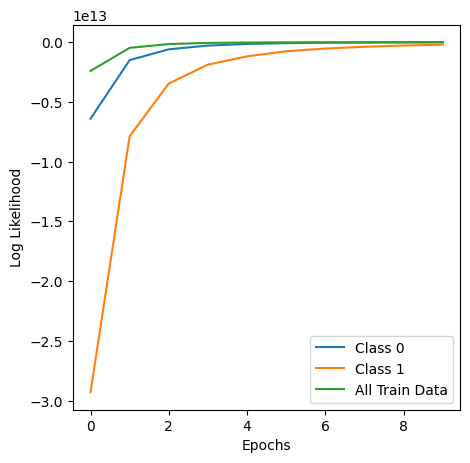

In [8]:
# Hyperparameters
input_dim = 3          # 3D accelerometer data (x, y, z)
hidden_dim = 64        # Adjusted hidden dimension for potentially better performance
state_dim = 15         # State dimension, can be tuned
batch_size = 64        # Batch size
num_epochs = 10         # Epochs for training
lr = 0.001             # Learning Rate
class_num = 2

# Check if CUDA is available
for i in range(torch.cuda.device_count()):
   print("cuda:%d=%s" % (i, torch.cuda.get_device_properties(i).name))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Pytorch device: ", device)

# Create DKFs
model_0 = DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device)
model_1 = DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device)
model_full = DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device)

x_windows = {c : [] for c in range(class_num)}

for x, y in zip(Xtr, Ytr):
   x_windows[y].append(x)

x_tensor_0 = torch.tensor(np.array(x_windows[0]), dtype=torch.float32)
x_tensor_1 = torch.tensor(np.array(x_windows[1]), dtype=torch.float32)
x_tensor_full = torch.tensor(Xtr, dtype=torch.float32)
x_dataloader_0 = DataLoader(x_tensor_0, batch_size=batch_size)
x_dataloader_1 = DataLoader(x_tensor_1, batch_size=batch_size)
x_dataloader_full = DataLoader(x_tensor_full, batch_size=batch_size)

print("Train for class 0 data")
ll_0 = model_0.train(x_dataloader_0, num_epochs, True)
print("\nTrain for class 1 data")
ll_1 = model_1.train(x_dataloader_1, num_epochs, True)
print("\nTrain for full data")
ll_full = model_full.train(x_dataloader_full, num_epochs, True)

fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("Epochs")
plt.ylabel("Log Likelihood")
plt.plot(range(0, num_epochs), ll_0, label="Class 0")
plt.plot(range(0, num_epochs), ll_1, label="Class 1")
plt.plot(range(0, num_epochs), ll_full, label="All Train Data")
plt.legend()

#Save for later
torch.save(model_0.state_dict(), "class_0_dkf.pt")
torch.save(model_1.state_dict(), "class_1_dkf.pt")
torch.save(model_full.state_dict(), "class_full_dkf.pt")


## DKM Classifier

In [4]:
class DKMClassifier():
    def __init__(self, sim_model : object, class_num: int, input_dim : int, 
                 hidden_dim : int, state_dim : int, lr : float, device : str):
        self.models = {c : DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device) 
                       for c in range(class_num)}
        self.class_num = class_num  
        self.sim_model = sim_model

    def fit(self, X : np.ndarray, Y : np.ndarray, epochs : int, batch_size : int):
        x_windows = {c: [] for c in range(self.class_num)}

        for x, y in zip(X, Y):
            x_windows[y].append(x)
        print("Fiting DKFs per class")
        for c in range(self.class_num):
            x_tensor = torch.tensor(np.array(x_windows[c]), dtype=torch.float32)
            x_dataloader = DataLoader(x_tensor, batch_size=batch_size)
            self.models[c].train(x_dataloader, epochs)

        # Fit similarity classifier
        X_f = self._seq_class_similarities(X, batch_size)
        print("Fitting underlying classifier")
        self.sim_model.fit(X_f, Y)

    def _seq_class_similarities(self, seqs : np.ndarray, batch_size : int):
        feature_sets = []
        seq_len = seqs.shape[1]
        for c in range(self.class_num):
            x_tensor = torch.tensor(seqs, dtype=torch.float32)
            x_dataloader = DataLoader(x_tensor, batch_size=batch_size)
            feature_sets.append(self.models[c].extract_latent_features(x_dataloader))
        
        feature_vec = np.concatenate(feature_sets, axis=1)
        #feature_vec /= seq_len
        return feature_vec

    def predict_proba(self, X : np.ndarray, batch_size : int):
        """
        Arguments follow convention for sklearn classifiers
        """
        X_f = self._seq_class_similarities(X, batch_size)
        prob = self.sim_model.predict_proba(X_f)
        return prob
    
    def predict(self, X : np.ndarray, batch_size : int):
        """
        Arguments follow convention for sklearn classifiers
        """
        X_f = self._seq_class_similarities(X, batch_size)
        pred = self.sim_model.predict(X_f)

        return pred

## Try Out DKM Classifier

cuda:0=NVIDIA GeForce RTX 3090
cuda:1=NVIDIA GeForce GTX 1050 Ti with Max-Q Design
Pytorch device:  cuda:0
Begin training
Fiting DKFs per class
Epoch [1/5], Loss: 56009854106.6945, Duration: 21.58 seconds
Epoch [2/5], Loss: 52090106.4565, Duration: 22.04 seconds
Epoch [3/5], Loss: 15597099.4592, Duration: 17.27 seconds
Epoch [4/5], Loss: 6424510.0630, Duration: 16.98 seconds
Epoch [5/5], Loss: 3079496.4151, Duration: 18.22 seconds
Epoch [1/5], Loss: 74669916051.0417, Duration: 7.87 seconds
Epoch [2/5], Loss: 225709300.0930, Duration: 6.43 seconds
Epoch [3/5], Loss: 79586387.6357, Duration: 6.58 seconds
Epoch [4/5], Loss: 40381219.0437, Duration: 6.73 seconds
Epoch [5/5], Loss: 24016419.1874, Duration: 6.54 seconds
Fitting underlying classifier
Begin Prediction for Training data
Accuracy = 0.926561
Precision = 0.952031
Recall = 0.767770
F1-score = 0.850030
Balanced Accuracy = 0.876692
Sober Accuracy = 0.985613
Drunk Accuracy = 0.767770
False negatives = 5835
False postives = 972
True ne

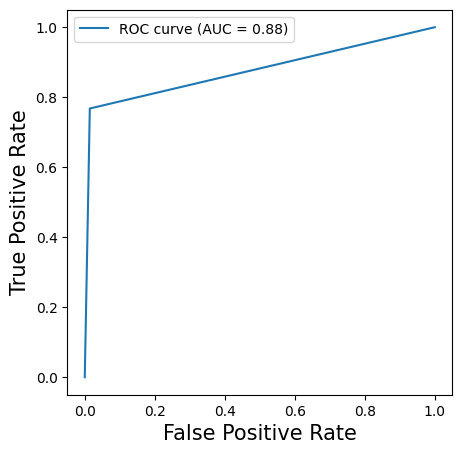

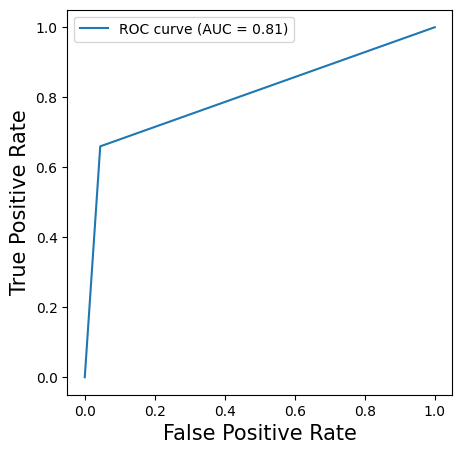

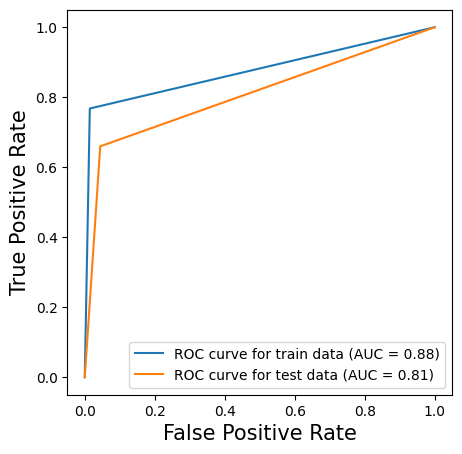

In [5]:
# Hyperparameters
input_dim = 3          # 3D accelerometer data (x, y, z)
hidden_dim = 64        # Adjusted hidden dimension for potentially better performance
state_dim = 15         # State dimension, can be tuned
batch_size = 64        # Batch size
num_epochs = 5         # Epochs for training
lr = 0.001             # Learning Rate

# Check if CUDA is available
for i in range(torch.cuda.device_count()):
   print("cuda:%d=%s" % (i, torch.cuda.get_device_properties(i).name))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Pytorch device: ", device)

# Create classifier
sim_model = RandomForestClassifier(random_state=1234, max_depth=15, n_jobs=-1, oob_score=True)
model = DKMClassifier(sim_model=sim_model, class_num=2, input_dim=input_dim, 
                                   hidden_dim=hidden_dim, state_dim=state_dim, 
                                   lr=lr, device=device)

print("Begin training")
model.fit(Xtr, Ytr, num_epochs, batch_size)

print("Begin Prediction for Training data")
y_pred1 = model.predict(Xtr, batch_size)
print_metrics(Ytr, y_pred1)

print("\n\nBegin Prediction for Test data")
y_pred2 = model.predict(Xva, batch_size)
print_metrics(Yva, y_pred2)

fig, ax = plt.subplots(figsize=(5, 5))
metrics.RocCurveDisplay.from_predictions(
    Ytr,
    y_pred1,
    name=f"ROC curve for train data",
    ax=ax,
)
metrics.RocCurveDisplay.from_predictions(
    Yva,
    y_pred2,
    name=f"ROC curve for test data",
    ax=ax,
)

plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
# plt.title("ROC Curves for Shuffled Data")
plt.legend()

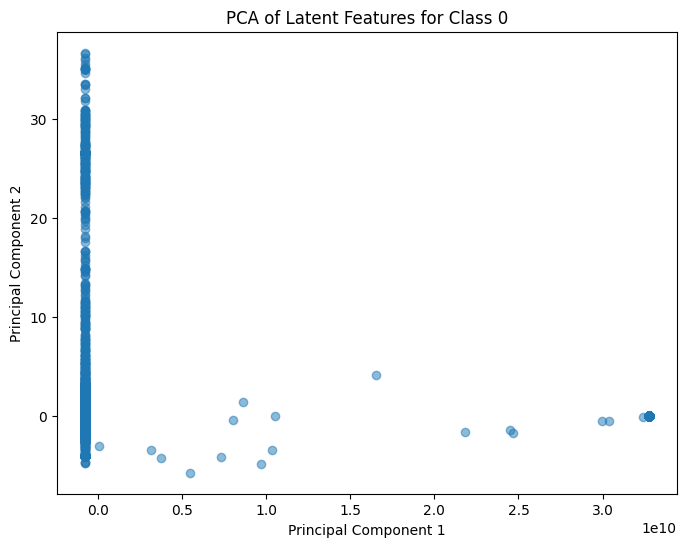

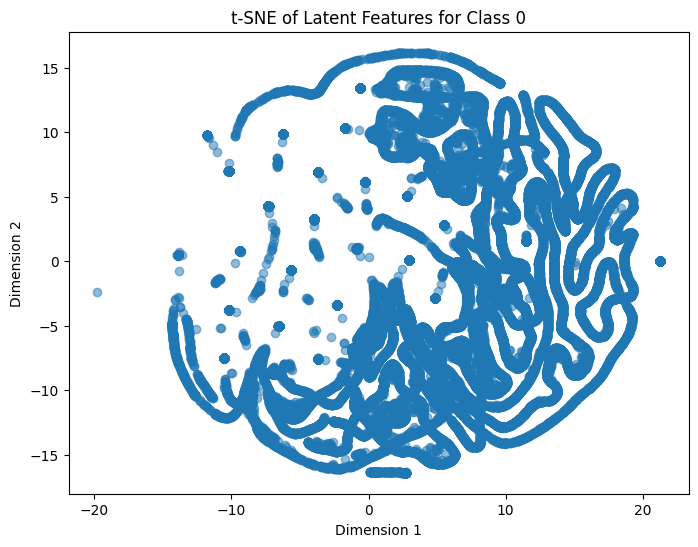

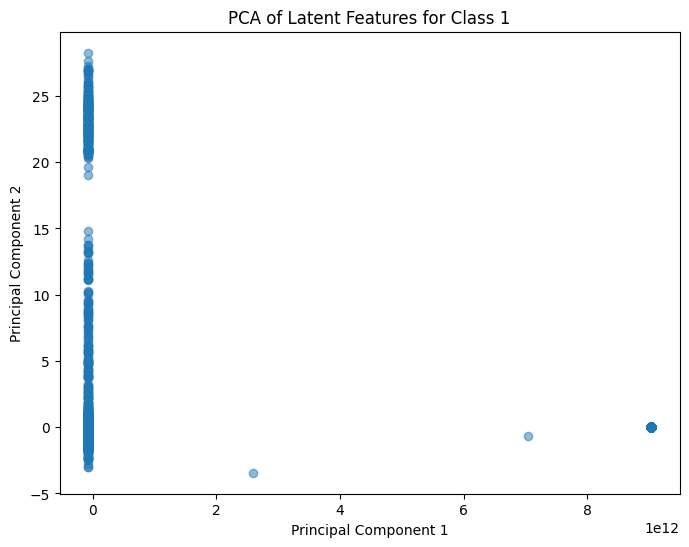

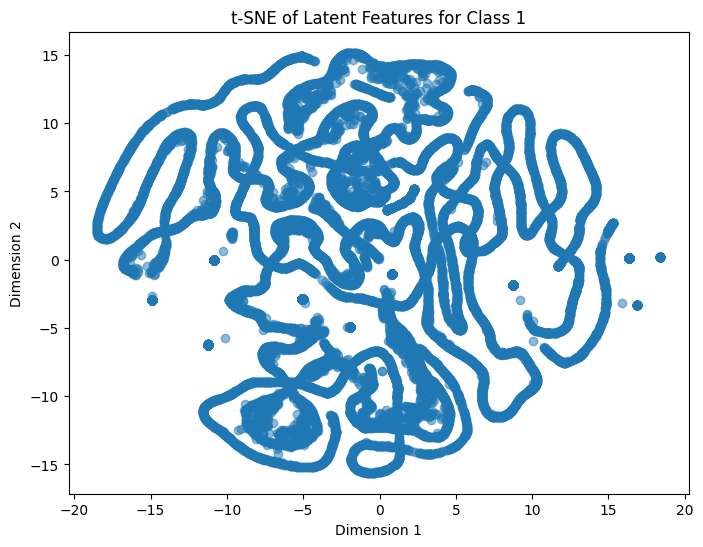

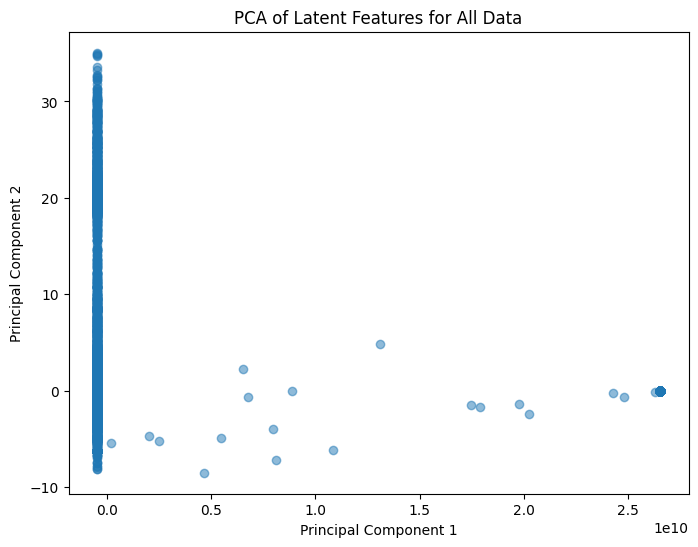

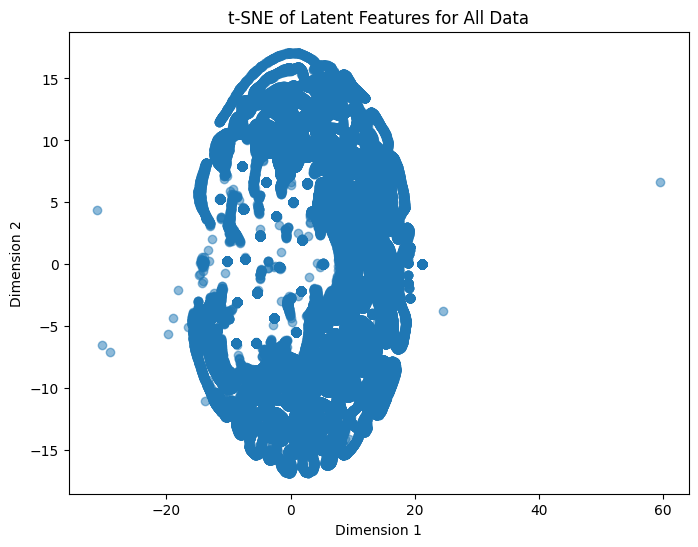

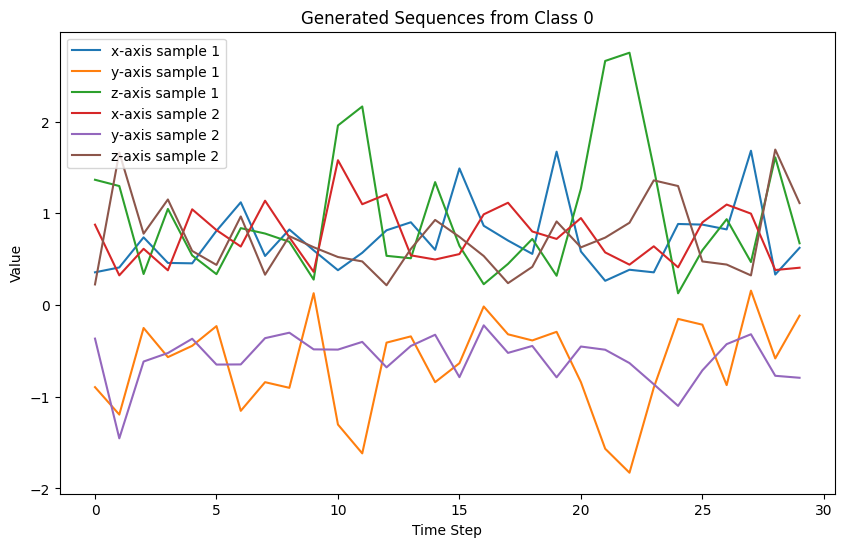

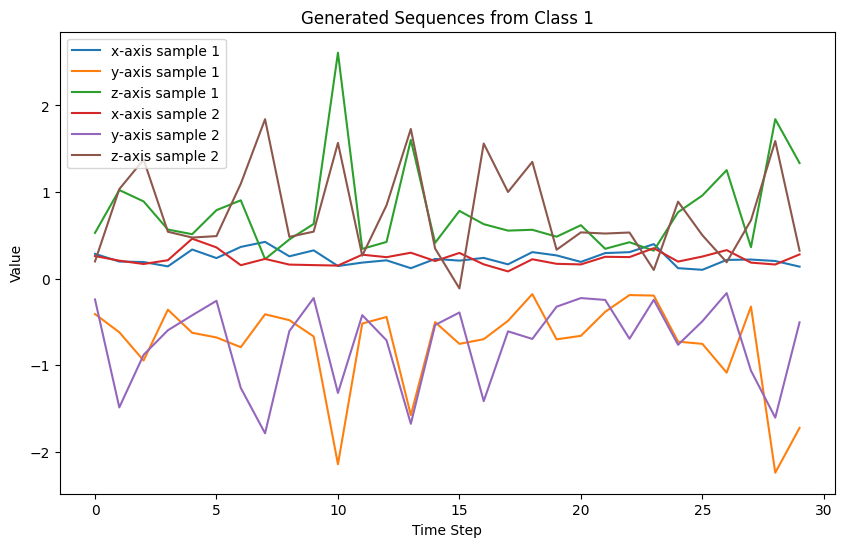

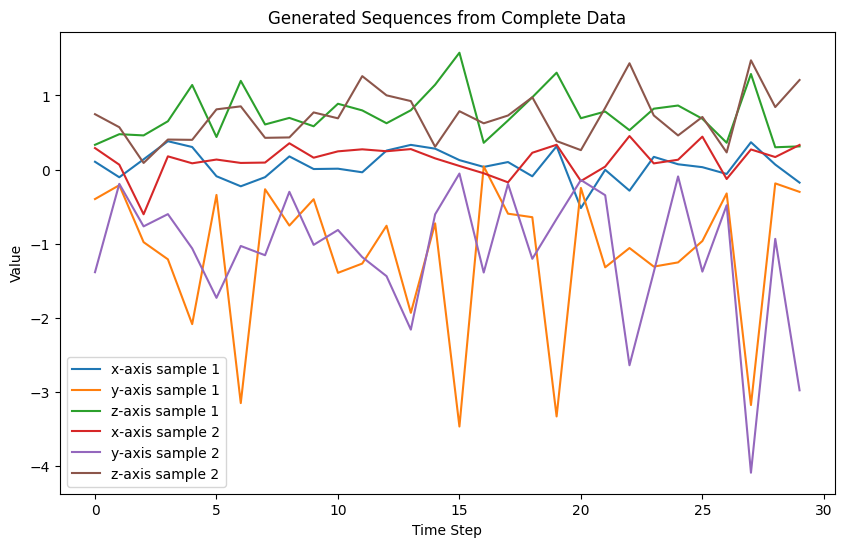

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchview import draw_graph

# Hyperparameters
input_dim = 3          # 3D accelerometer data (x, y, z)
hidden_dim = 64        # Adjusted hidden dimension for potentially better performance
state_dim = 15         # State dimension, can be tuned
batch_size = 64        # Batch size
num_epochs = 10         # Epochs for training
lr = 0.001             # Learning Rate
class_num = 2

# Create DKFs
model_0 = DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device)
model_0.load_state_dict(torch.load("class_0_dkf.pt"))
model_1 = DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device)
model_1.load_state_dict(torch.load("class_1_dkf.pt"))
model_full = DeepKalmanFilter(input_dim, hidden_dim, state_dim, lr, device)
model_full.load_state_dict(torch.load("class_full_dkf.pt"))

#Create Dataloaders
x_windows = {c : [] for c in range(class_num)}
for x, y in zip(Xtr, Ytr):
   x_windows[y].append(x)
x_tensor_0 = torch.tensor(np.array(x_windows[0]), dtype=torch.float32)
x_tensor_1 = torch.tensor(np.array(x_windows[1]), dtype=torch.float32)
x_tensor_full = torch.tensor(Xtr, dtype=torch.float32)
x_dataloader_0 = DataLoader(x_tensor_0, batch_size=batch_size)
x_dataloader_1 = DataLoader(x_tensor_1, batch_size=batch_size)
x_dataloader_full = DataLoader(x_tensor_full, batch_size=batch_size)

def plot_visualizations(dkf : DeepKalmanFilter, dataloader : DataLoader, name : str):
    latent_features = dkf.extract_latent_features(dataloader)
    # PCA Visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(latent_features)
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.5)
    plt.title('PCA of Latent Features for %s' % name)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    # t-SNE Visualization
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_features = tsne.fit_transform(latent_features)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.5)
    plt.title('t-SNE of Latent Features for %s' % name)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_visualizations(model_0, x_dataloader_0, "Class 0")
plot_visualizations(model_1, x_dataloader_1, "Class 1")
plot_visualizations(model_full, x_dataloader_full, "All Data")

# Generate and visualize samples from the posterior
seq_length = 30
num_sequences = 2
def visualize_generated_samples(dkf : DeepKalmanFilter, seq_length : int, num_sequences : int, name : str):
    plt.figure(figsize=(10, 6))
    generated_samples = dkf.generate(seq_length, num_sequences)
    for i, sample in enumerate(generated_samples):
        plt.plot(range(0, seq_length), sample.T[0], label=f"x-axis sample {i+1}")
        plt.plot(range(0, seq_length), sample.T[1], label=f"y-axis sample {i+1}")
        plt.plot(range(0, seq_length), sample.T[2], label=f"z-axis sample {i+1}")
    plt.title(f'Generated Sequences from {name}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

visualize_generated_samples(model_0, seq_length, num_sequences, "Class 0")
visualize_generated_samples(model_1, seq_length, num_sequences, "Class 1")
visualize_generated_samples(model_full, seq_length, num_sequences, "Complete Data")


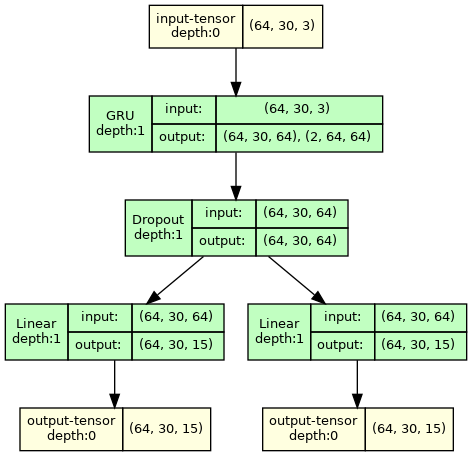

In [5]:
# Draw diagram of model
graphviz.set_jupyter_format("png")
model_graph = draw_graph(
    InferenceModel(input_dim, hidden_dim, state_dim),
    graph_name="Inference Model",
    input_size=(batch_size, seq_length, input_dim),
    dtypes=[torch.float32],
)
model_graph.visual_graph

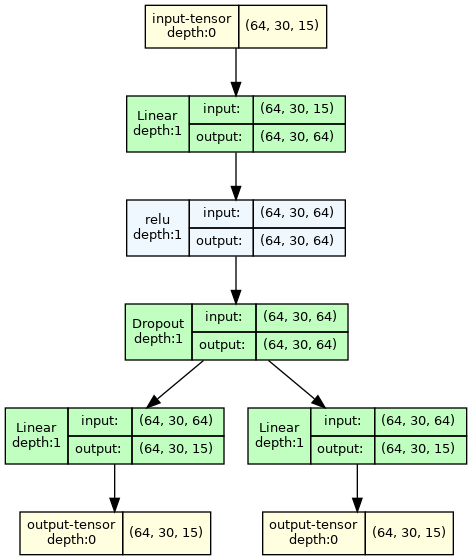

In [6]:
model_graph2 = draw_graph(
    StateTransitionModel(state_dim, hidden_dim),
    graph_name="State Transition Model",
    input_size=(batch_size, seq_length, state_dim),
    dtypes=[torch.float32],
)
model_graph2.visual_graph

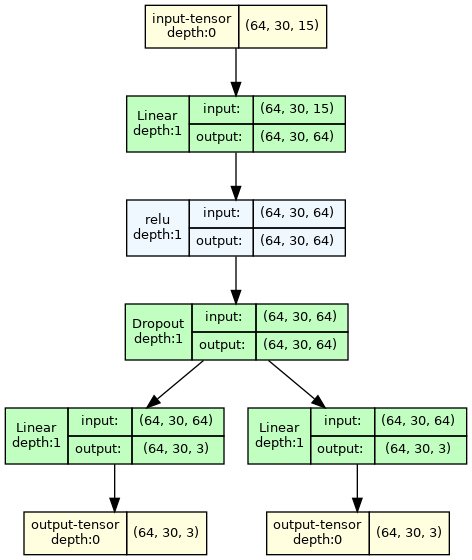

In [7]:
model_graph3 = draw_graph(
    EmissionModel(state_dim, hidden_dim, input_dim),
    graph_name="Emission Model",
    input_size=(batch_size, seq_length, state_dim),
    dtypes=[torch.float32],
)
model_graph3.visual_graph